We want to show that spatial movement of humans (and likely other animals too) is not scale-free but rather, bound by multiple levels of *containers*.

Containers are nested regions in space such as *city*, *neighborhood*, and *building*—the *city* contains *neighborhoods* and each *neighborhood* contains *buildings*. This multi-level description of space as a tree of nested containers is in theory unbounded, but for practical purposes related to describing human mobility, we can currently say that the root container is *planet Earth* and the furthest leaf container is something like a *table* class where nodes are *chair*. As a moves around in the world, she occupies different nodes in the tree of containers. If she is a home, movements between *room* containers can be described as a multi-level walk on all containers smaller than *building* (including *building*). What I mean by this is that at the *building* level where each *room* container is a node, there is a walk. At the *room* level, however, there is also a set of walks (one for each *room* container). When she goes to the *kitchen*, for example, time spent there is stationary from the *building*-level perspective, but on the *room*-level there is all sorts of important movement: she may walk between the stove, the towel rack, the sink and the refrigerator in any order. For now we will consider these entities leaf nodes of the tree of containers, but in theory, they need not be.

How do we show that mobility behaves according to this description of space? I have a few ideas, which we need to test:
* *Transitions between nodes inside a container are random.* If this is the case, inferring the different containers should not be too hard, because it allows us to view the network as a multi-level random graph. Can we make an **algorithm that searches for multiple scales of random graphs?**
* We can possibly run a **multi-level community detection algorithm** to a graph of transitions between small stop-locations, and see how many levels meaningfully describe the network. Infomap is a good candidate here, because the graph describes flow.
* From the perspective of different containers, we can estimate what movements have destination and which lack destination. The idea is that from the perspective of a given container, transitions are mostly random, so consecutive movements are rarely in the same direction (small or negative dot product). However, from the perspective of that same container, of two consecutive movements are in the same direction (large positive dot product) then it means that the walker is leaving that container. Yet at the level of the super-container this is just another step in a random walk where the container was a node. Not sure how to implement this, but it seems to be a good way to look at the problem.
The **strategy** then is:
    1. Take all the raw location data.
    2. Compute each points's delta vector (row-wise subtract). Remove 0th point.
    3. Compute dot products between delta vectors (row-wise dot product).
    4. We now know if movement is directed (positive DP) or non-directed (negative DP). The magnitude of the DPs carries information about the scale at which a person moves, but we need to figure out how to deal with this.

In [73]:
%matplotlib inline
from sensible_raw.loaders import loader
import pandas as pd
import datetime, pytz
from tzwhere import tzwhere
import calendar as cal
from collections import Counter
import matplotlib.pylab as plt
import sys
import math
import heapq
import operator
import random
import numpy as np
import time

# Utility functions

## Clustering

In [71]:

class Cluster(object):
    def __init__(self, a): 
        self.center = a
        self.size = 0
        
    def add(self, e):
        self.size += kernel(self.center, e)
        self.center += (e - self.center) / self.size
        
    def merge(self, c):        
        self.center = (self.center * self.size + c.center * c.size) / (self.size + c.size)
        self.size += c.size

    def resize(self, dim):
        extra = np.zeros(dim - len(self.center))
        self.center = np.append(self.center, extra)
        
    def __str__(self):
        return "Cluster( %s, %f )" % (self.center, self.size)

class Dist(object):
    """this is just a tuple, 
    but we need an object so we can define cmp for heapq"""
    def __init__(self, x, y, d):
        self.x = x
        self.y = y
        self.d = d
    def __cmp__(self, o):
        return cmp(self.d, o.d)
    def __str__(self):
        return "Dist(%f)" % (self.d)

class OnlineCluster(object):
    """Online clustering model.
    
    A new points comes in. If it is the first, a cluster gets created on its location.
    When the next comes in it's assigned to the closest existing cluster, and a new
    cluster is created in its place. When len(self.clusters) >= self.N, the algorithm
    starts merging clusters. It still creates new kernels, but in most cases it just
    merges them with existing ones.
    
    At the end, clusters with fewer members than some threshold (mean(size) * thr) are
    removed, to create a solution with less than self.N kernels.
    
    Source: http://gromgull.net/blog/2009/08/online-clustering-in-python/
    
    Input
    -----
        N : Number of kernels (int)
        thr : Threshold to apply for trimming (float)
        kernel : Kernel function to use (function)
    """
    
    
    def __init__(self, N, thr, kernel=None):
        """N - 1 is the largest number of clusters I can find
        Higher N makes me slower"""
        
        self.n = 0
        self.N = N
        self.thr = thr
        
        if kernel is None:
            # Assume gaussian Kernel
            self.kernel = self._kernel_normalise(self._kernel_gauss)
        else:
            self.kernel = kernel
                
        self.clusters = []
        # max number of dimensions we've seen so far
        self.dim = 0 

        # cache inter - cluster distances
        self.dist = []
        
    def _kernel_gauss(self, x, y, sigma=0.00001):
        v = x - y
        l = math.sqrt(np.square(v).sum())
        return math.exp( - sigma * (l**2))
    
    def _kernel_normalise(self, k): 
        return lambda x, y: k(x, y) / math.sqrt(k(x, x) + k(y, y))
    
    def _kernel_dist(self, x, y, kernel):
        return 2 - 2 * kernel(x, y)

    def resize(self, dim):
        for c in self.clusters:
            c.resize(dim)
        self.dim = dim
        
    def cluster(self, e):
    
        # Adjust kernel kernel dimensionality
        if len(e) > self.dim:
            self.resize(len(e))
                            
        if len(self.clusters) > 0: 
            # compare new points to each existing cluster
            c = [
                (i, self._kernel_dist(x.center, e, self.kernel))
                for i, x in enumerate(self.clusters)
            ]
            closest = self.clusters[min(c, key=operator.itemgetter(1))[0]]
            closest.add(e)
            
            # invalidate dist - cache for this cluster
            self.updatedist(closest)

        if len(self.clusters) >= self.N and len(self.clusters) > 1:
            # merge closest two clusters
            m = heapq.heappop(self.dist)
            m.x.merge(m.y)

            self.clusters.remove(m.y)
            self.removedist(m.y)
            
            self.updatedist(m.x)

        # make a new cluster for this point
        newc = Cluster(e)
        self.clusters.append(newc)
        self.updatedist(newc)
        
        self.n += 1
    
    def removedist(self, c):
        """invalidate intercluster distance cache for c"""
        
        r = [x for x in self.dist if x.x == c or x.y == c]
                
        for x in r:
            self.dist.remove(x)
            
        heapq.heapify(self.dist)
        
    def updatedist(self, c):
        """Cluster c has changed, re - compute all intercluster distances"""
        self.removedist(c)

        for x in self.clusters:
            if x == c: continue
            d = self._kernel_dist(x.center, c.center, self.kernel)
            t = Dist(x, c, d)
            heapq.heappush(self.dist, t)
                
    def trimclusters(self):
        """Return only clusters over threshold"""
        t = np.mean([x.size for x in filter(lambda x: x.size > 0, self.clusters)]) * self.thr
        return filter(lambda x: x.size >= t, self.clusters)

## Data handling

In [76]:
def local_dt_from_ts_and_geo(ts, lat, lon, tzobj=None):
    """Take UNIX timestamp and coordinates and return location aware datetime object.

    Input
    -----
        ts : int
        lat : float
        lon : float
        tzobj : tzwhere.tzwhere(forceTZ=True)
            Always give the function a tzobj. They take a while to create, so doing it
            for each function call is very expensive.
            
    Output
    ------
        out : datetime.datetime
    """
    if tzobj is None:
        tzobj = tzwhere.tzwhere(forceTZ=True)
    location = tzobj.tzNameAt(lat, lon, forceTZ=True)
    if location is None:
        print "Warning: lat, lon is not associated with any location"
    local_tz = pytz.timezone(location)
    dt_utc0 = datetime.datetime.fromtimestamp(ts).replace(tzinfo=pytz.utc)
    return dt_utc0.astimezone(local_tz)

def haversine(coord1, coord2):
    """Haversine distance between two sets of coordinates."""
    def _to_rad(degrees):
        return degrees * 2 * np.pi / 360.
    
    lat1, lat2 = _to_rad(coord1[:, 0]), _to_rad(coord2[:, 0])
    dlat = _to_rad(coord1[:, 0] - coord2[:, 0])
    dlon = _to_rad(coord1[:, 1] - coord2[:, 1])

    a = np.sin(dlat / 2) ** 2 + \
        np.cos(lat1) * np.cos(lat2) * \
        np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    return 6371e3 * c  # Meters

def get_datatype_period(datatype, period):
    """Get data for a datatype and list of periods."""
    df = pd.DataFrame()
    for month in period:
        columns, data = loader.load_data(datatype, month)
        df = pd.concat([df, pd.DataFrame(dict(zip(columns, data)))])
    return df

# Data

In [78]:
all_periods = [
    "%s_%s" % (month.lower(), year)
    for year in ["2013", "2014", "2015", "2016"]
    for month in [cal.month_name[m] for m in range(1, 13)]
]

# Get a list of all periods like ['january_2013', 'february_2013', ...]
all_periods = [
    "%s_%s" % (month.lower(), year)
    for year in ["2013", "2014", "2015", "2016"]
    for month in [cal.month_name[m] for m in range(1, 13)]
]

# Put all stop-location events into `df_stops`
df_locations = get_datatype_period("location", all_periods)

# Extract users from dataset
users = np.sort(df_locations['user'].unique())

In [112]:
df_u = df_locations[df_locations['user'] == 58].sort_values("timestamp")
coords_u = np.array(df_u[['lat', 'lon']])

In [123]:
d_dist = haversine(coords_u[:-1, :], coords_u[1:, :])
d_dist = np.insert(d_dist, 0, 0)

In [125]:
df_u['d_dist'] = d_dist

In [126]:
df_u

,lat,lon,timestamp,user,d_dist
0,55.788467,12.531848,1377986400000,58,0.000000
1,55.788467,12.531848,1377987300000,58,0.000000
2,55.788417,12.531847,1377988200000,58,5.593999
3,55.788427,12.532023,1377989100000,58,11.109879
4,55.788468,12.531847,1377990000000,58,11.895090
5,55.788458,12.531944,1377990900000,58,6.125396
6,55.788607,12.531964,1377991800000,58,16.579799
7,55.788609,12.531994,1377992700000,58,1.911091
20,55.788615,12.532020,1377993600000,58,1.769997
21,55.788614,12.531999,1377994500000,58,1.345695


I clustered 600 points in 1.32 seconds and found 5 clusters.


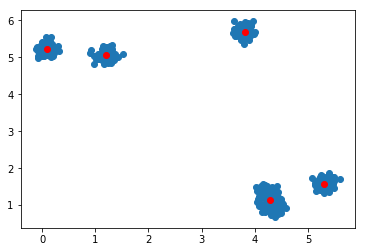

In [70]:
# The value of N is generally quite forgiving, i.e.
# giving 6 will still only find the 3 clusters.
# around 10 it will start finding more

plot = True
K = 6
thr = 0.1
N = 10

# Create K random 2D gaussian clusters
points = []
for i in range(K):
    x = random.random() * K
    y = random.random() * K
    c = [
        np.array((x + random.normalvariate(0, 0.1), y + random.normalvariate(0, 0.1)))
        for j in range(100)
    ]
    points += c

if plot: pylab.scatter([x[0] for x in points], [x[1] for x in points])

random.shuffle(points)
n = len(points)

start = time.time()

c = OnlineCluster(N, thr)
while len(points)>0:
    c.cluster(points.pop())

clusters = c.trimclusters()
print "I clustered %d points in %.2f seconds and found %d clusters."%(n, time.time() - start, len(clusters))

if plot: 
    cx = [x.center[0] for x in clusters]
    cy = [y.center[1] for y in clusters]

    pylab.plot(cx, cy, "ro")
    pylab.draw()
    pylab.show()


In [47]:
points = []
for i in range(K):
    x = random.random() * K
    y = random.random() * K
    c = [
        np.array((x + random.normalvariate(0, 0.1), y + random.normalvariate(0, 0.1)))
        for j in range(100)
    ]
    points += c